### Neural Network student performace

- I denne filen kommer jeg til å ta for meg trening og tuning av neural network klasifikasjon for student performace datasettet. Jeg kommer til å bruke tensorflow keras Sequential og Model med og uten et dropoutlayer og sammelige hvilke av disse alternativere som prestere best.

- Siden deler av kommentarene i denne oppgaven vil være gjeldene for alle delene av oblig3 og 4 vil jeg skrive de samme eller veldig like kommentarer der hvor dette er hensiktsmessig i alle filene for disse oppgavene, men tilføre videre spesifikke kommentarer for den enkelte filen/oppgaven der hvor dette er hensiktsmessig.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, get_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasClassifier

In [44]:
df = pd.read_csv(r"..\..\oblig3_og_4\student_performance.csv", delimiter=";")

In [45]:
targets = pd.Series(np.array(LabelEncoder().fit_transform(df['Target'])))
features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)

In [46]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'), 
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)


#### Beskrivelser av metoder for trening, tuning og testing av datasettet
- For å test og tune modellene har jeg laget en nested CV funksjon som bruker GridSearchCV som den indre loopen. Ut av denne funksjonen så får vi returnert den beste modellen for hver runde av den ytere loopen, de tilhørende scoring resultatene for både train og test oppsplittingen, og resultatene fra selve GridSearchCV modellen, som blant annet kan brukes til å visualisere parameter tuningen.

- Grunnen til at jeg har valgt å bruke et slik oppsett er at dette tillater meg å trene og tune modellene på hele datasettet uten at modellen overfiter til datasettet som en helhet. Dette gjør at resultatene du får ut fra denne typen validering i større grad vil ha god overførings verdi til hele datasettet for videre bruk.

- Måten dette oppnås på er at datasettet i yter loopen blir delt opp i for eks. 5 deler hvor du bruker 4 av disse dele til trening av modellene og den siste delen til testing. I den indre loopen splitter du igjen opp testdelen av data settet i for eks. 4 deler, hvor da 3 av disse brukes til trening av modellen og 1 del til testing/validering. På denne måte får du benyttet hele datasettet til trening og validering av modellene uten at den enkelte test delen av datasettet har blitt brukt til trening av modellen i forbindelse med sin vurdering av prestasjonen til modellen.

- Jeg har også lagt inn fuksjonalitet for å kunne endre antall spliter i ytter og inner loopene for treningen av modelene, noe som er kan være veldig nytt for å kunne redusere kjøretiden til fuksjonen ved utprøving av forskjellige tuning parameter.

- For oppdelingen av datasettet har jeg bruk StratifiedKFold slik at det oppnå så lik som mulig fordeling av target klassene mellom de forskjellige oppsplittingene av datasettet.

- For å vurdere disse modellene har jeg valgt å bruke disse metricene Accuracy, Precision, Recall og F1-score. Jeg ønsket i utgangspunktet også å inkludere Roc_auc men jeg fikk noen problemer med å implemntere denne for keras modellene så jeg valgt å ikke da den med i denne vurderingen.

- Accuracy er et mål på hvor treffsikre prediksjonene er for hele datasettet. Precision er et mål på hvor godt modellen klarer å predikere positive representasjoner for den enkelte klassen målt opp mot det totale antallet positive prediksjoner. Recall er et mål på hvor godt modellen klarer å predikere positive repsentasjoner for den enkelte klassen målt opp mot det det faktiske antalle av positive representasjoner. F1-score er en samlet representasjon av precision og recall som balansere hverandre slik at du en god verdi på den enne av disse vil balanseres av den dårlig verdi på den andre.

- For precision, recall, og f1, er det imidlertid hvert å merke seg at disse metricene i utgangspunktet er laget for å vurdere binære klassifikasjoner og at derfor må disse vurderes enkeltvis og så samles, jeg har valgt å bruke et uvektet macro gjennomsnitt for å oppnå dette.

- For å unngå eksponentiell kjøretid ved tuningen av modellene kommer jeg til å dele opp tuningen i midre deler slik at kjøretiden blir lettere håndterbar. Utover dette kommer jeg til å gjennomføre noe videre tuning og testing av modellene som ikke vil være inkludert i de endelige fila av hensyn til å gjøre dokumentet mer oversiktig og lett forstålig, men jeg kommer til å dokumentere den helheltlige prossens slik at det mulig å se en rød tråd gjennom tuningen av modellene. 

#### Tensorflow Keras 

- Som første modell starter jeg med en Keras Sequential modell som har 3 hidden layers i tillegg til input og utput layer. 

-  For alle modellene komm jeg til å bruke softmax som aktiverings fuksjon for output layeret da det er denne som er bergnet for denne typen datasett. For loss function så bruks sparse categorical crossentropy da det er denne function som er riktig å bruke for klassifikasjons datasett med flere utput klasser og ikke et binært output.

- For tuningen av modellene kommer jeg til å fokusere på følgene verdier, aktiverings funksjon for hidden layers, optimizer ved compilering, antall nevroner for 1 og 2 hidden layer, batch size, learing rate for optimizer og dropout for de modellene som inkludere dropout layer.

- Jeg har gjort en grunnleggen sjekk i forkant sli at tuning verdiene jeg starter ikke er for langt unna jeg som blir slutt resultatet. Jeg valg å gjøre dette da parametere som er veldig ulik slutt resultat vil kunne påvirker resultatet for tuningene av de forskjellige parameterene. 

- Det kunne selfølgelig vært implementert endre mere utfylende tuning og utprøving av antall hidden layers, forskjellige activation functions for de individuelle hidden layers osv. Men jeg har valgt å begrense tuningen min til det utvalget jeg har gjort ut fra tidshensyn og det totale omfanget, da jeg mener at dette tilstrekkelig demonstere god forståelse for tuning prosessen og hvilke mulighet det er og hvilke hensyn som bør tas.  

In [31]:
def create_model(optimizer="adam", loss='sparse_categorical_crossentropy', activation='relu', hidden_neurons1=144, hidden_neurons2=72):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model
keras_sequential = KerasClassifier(model=create_model, verbose=0)

In [ ]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [72],      
    'model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'model__activation': ['relu', 'tanh', 'elu', 'swish'],
}
keras_estimators, keras_scores_train, keras_scores_test, keras_cv_results = train(features, targets, keras_sequential, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

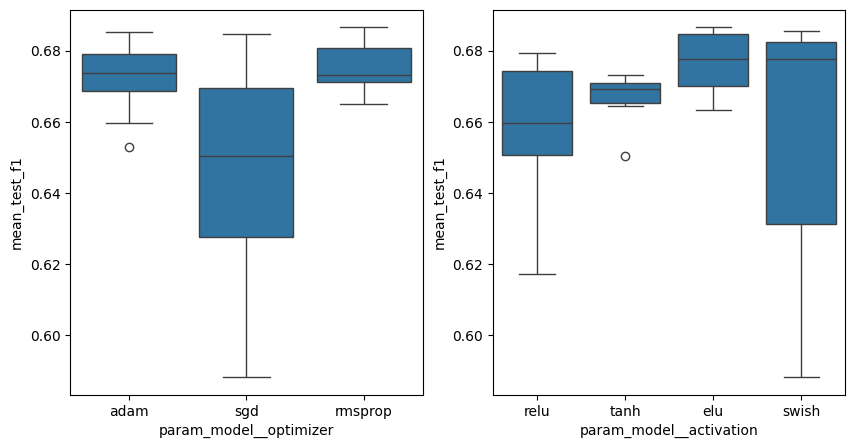

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results, x='param_model__optimizer', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results, x='param_model__activation', y='mean_test_f1', ax=ax[1])


In [9]:
keras_scores_test.describe()

,accuracy,precision,recall,f1
count,3.000000,3.000000,3.000000,3.000000
mean,0.764919,0.706333,0.677857,0.685925
std,0.001349,0.004395,0.003081,0.002790
min,0.763390,0.701268,0.674303,0.683934
25%,0.764407,0.704933,0.676904,0.684331
50%,0.765424,0.708598,0.679506,0.684728
75%,0.765683,0.708866,0.679635,0.686921
max,0.765943,0.709134,0.679764,0.689114


In [10]:
keras_scores_train.describe()

,accuracy,precision,recall,f1
count,3.000000,3.000000,3.000000,3.000000
mean,0.823915,0.795569,0.752304,0.766979
std,0.006871,0.005925,0.011605,0.009970
min,0.819261,0.792074,0.742683,0.758842
25%,0.819969,0.792148,0.745859,0.761418
50%,0.820678,0.792223,0.749035,0.763994
75%,0.826243,0.797316,0.757114,0.771047
max,0.831807,0.802410,0.765193,0.778100


In [169]:
keras_estimators

[KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=elu
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=

In [12]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [108, 144, 180],
    'model__hidden_neurons2': [72],      
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'elu', 'swish'],
}
keras_estimators_2, keras_scores_train_2, keras_scores_test_2, keras_cv_results_2 = train(features, targets, keras_sequential, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

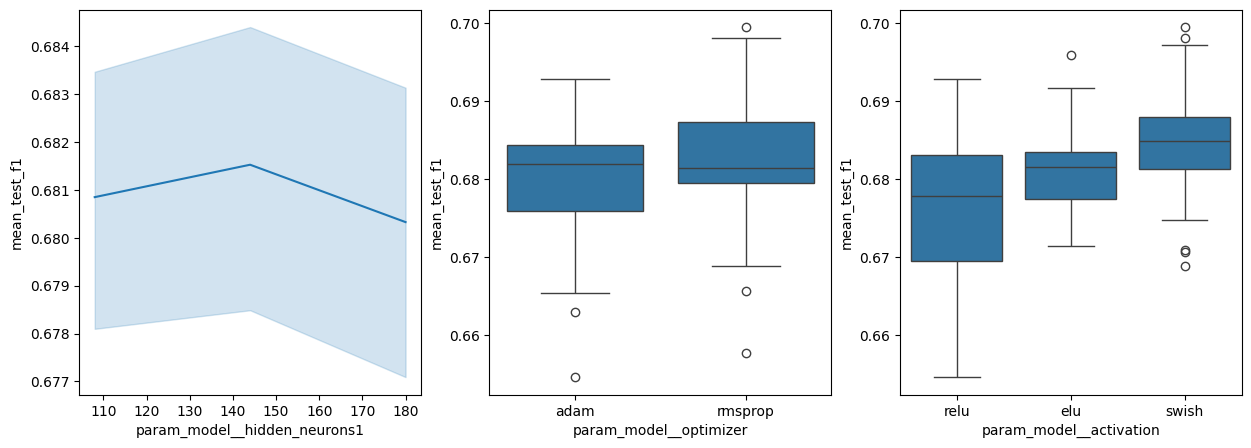

In [13]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=keras_cv_results_2, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_2, x='param_model__optimizer', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=keras_cv_results_2, x='param_model__activation', y='mean_test_f1', ax=ax[2])

In [14]:
keras_scores_test_2.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.761979,0.702489,0.675901,0.682652
std,0.007968,0.010372,0.007676,0.008314
min,0.750282,0.687853,0.665457,0.670964
25%,0.757919,0.697079,0.672993,0.678507
50%,0.764972,0.703701,0.676767,0.684730
75%,0.766102,0.709904,0.677704,0.686085
max,0.770621,0.713906,0.686585,0.692975


In [15]:
keras_scores_train_2.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.823463,0.793742,0.753684,0.766882
std,0.016420,0.022725,0.027318,0.027618
min,0.806725,0.774882,0.719441,0.733043
25%,0.817514,0.782320,0.741149,0.756066
50%,0.818028,0.787721,0.751873,0.763030
75%,0.824527,0.790869,0.762623,0.773852
max,0.850523,0.832920,0.793335,0.808421


In [16]:
keras_estimators_2

[KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=elu
 	model__hidden_neurons1=180
 	model__hidden_neurons2=72
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=

In [32]:
keras_class_param = {
    'batch_size': [5, 10, 20],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36, 72, 108],      
    'model__optimizer': ['rmsprop'],
    'model__activation': ['swish'],
}
keras_estimators_3, keras_scores_train_3, keras_scores_test_3, keras_cv_results_3 = train(features, targets, keras_sequential, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_batch_size', ylabel='mean_test_f1'>

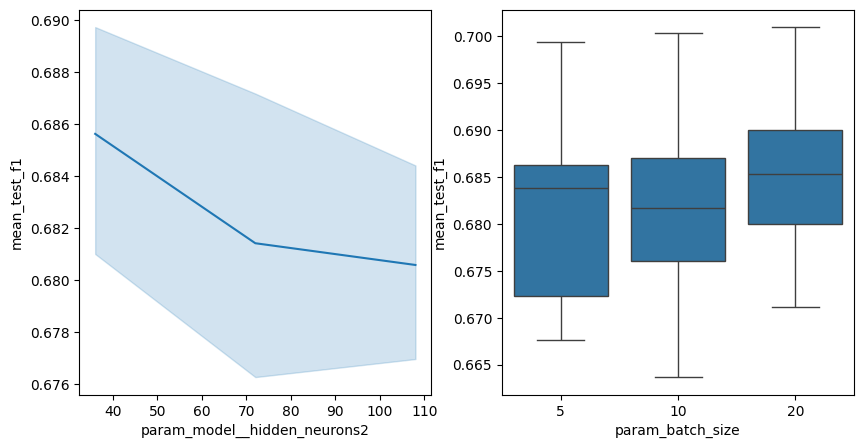

In [35]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_3, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_3, x='param_batch_size', y='mean_test_f1', ax=ax[1])


In [36]:
keras_scores_test_3.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.761983,0.705402,0.680843,0.689062
std,0.011846,0.013616,0.012661,0.012611
min,0.745763,0.690440,0.662523,0.671918
25%,0.757062,0.698164,0.673429,0.681529
50%,0.760452,0.698681,0.685415,0.690287
75%,0.770621,0.718862,0.689724,0.698672
max,0.776018,0.720861,0.693125,0.702904


In [37]:
keras_scores_train_3.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.817812,0.783781,0.751266,0.763500
std,0.006948,0.012256,0.008423,0.009558
min,0.807573,0.765672,0.736839,0.747605
25%,0.814072,0.777291,0.752759,0.762691
50%,0.820621,0.788363,0.752789,0.766990
75%,0.821984,0.791625,0.755229,0.767601
max,0.824809,0.795955,0.758710,0.772616


In [41]:
keras_estimators_3

[KerasClassifier(
 	model=<function create_model at 0x00000237F986E520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000237F986E520>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=108
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x00000237F986E520>
 	build_fn=None
 	warm_

In [54]:
def create_model_2(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=72, learing_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=RMSprop(learning_rate=learing_rate), loss=loss, metrics=['accuracy'])
    return model
keras_sequential_2 = KerasClassifier(model=create_model_2, verbose=0)

In [55]:
keras_class_param = {
    'batch_size': [20, 30],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.0001, 0.0005, 0.001, 0.01],
}
keras_sequential_2 = KerasClassifier(model=create_model_2, verbose=0)
keras_estimators_4, keras_scores_train_4, keras_scores_test_4, keras_cv_results_4 = train(features, targets, keras_sequential_2, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__learing_rate', ylabel='mean_test_f1'>

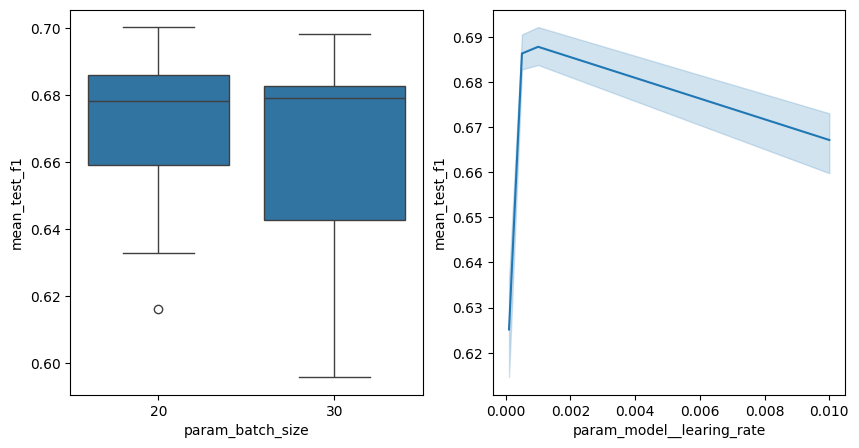

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_4, x='param_batch_size', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_4, x='param_model__learing_rate', y='mean_test_f1', ax=ax[1])


In [57]:
keras_scores_test_4.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.768536,0.715220,0.685098,0.694164
std,0.011468,0.013315,0.012615,0.012105
min,0.750282,0.699660,0.665959,0.676718
25%,0.768362,0.711036,0.682822,0.691593
50%,0.770362,0.711105,0.683586,0.691777
75%,0.771751,0.718550,0.696556,0.702328
max,0.781921,0.735751,0.696567,0.708405


In [59]:
keras_scores_train_4.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.807244,0.769024,0.732148,0.744617
std,0.010326,0.015003,0.016047,0.016213
min,0.792314,0.747339,0.707925,0.719712
25%,0.802487,0.761994,0.723573,0.736612
50%,0.809551,0.772191,0.740645,0.753735
75%,0.812429,0.777092,0.743224,0.755822
max,0.819441,0.786503,0.745372,0.757203


In [61]:
keras_estimators_4

[KerasClassifier(
 	model=<function create_model_2 at 0x00000238BBF43CE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.001
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x00000238BBF43CE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.0005
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x00000238BBF43CE0>
 	build_fn=None

In [62]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.001],
}
keras_sequential_estimators_final, keras_sequential_scores_train_final, keras_sequential_scores_test_final, keras_sequential_cv_results_final = train(features, targets, keras_sequential_2, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [63]:
keras_sequential_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.766500,0.712294,0.678364,0.687600
std,0.005827,0.010568,0.008931,0.008512
min,0.758192,0.700921,0.669058,0.677345
25%,0.763575,0.702863,0.672230,0.681528
50%,0.767232,0.711969,0.676012,0.686918
75%,0.770621,0.721253,0.683327,0.694945
max,0.772881,0.724463,0.691195,0.697262


In [65]:
keras_sequential_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.821146,0.793346,0.747592,0.762934
std,0.005463,0.008805,0.009914,0.010424
min,0.816050,0.786297,0.734837,0.750121
25%,0.817180,0.788761,0.743744,0.759174
50%,0.820571,0.788980,0.746126,0.760211
75%,0.822034,0.794550,0.751612,0.766986
max,0.829895,0.808141,0.761641,0.778180


In [66]:
def create_model_3(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=36, dropout=0.1):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=RMSprop(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model

fortsett her.......

In [67]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__activation': ['swish'],
    'model__dropout': [0.05, 0.1, 0.15, 0.2]
}
keras_sequential_dropout = KerasClassifier(model=create_model_3, verbose=0)
keras_estimators_6, keras_scores_train_6, keras_scores_test_6, keras_cv_results_6 = train(features, targets, keras_sequential_dropout, keras_class_param, outer_splits=5, inner_splits=4)

KeyboardInterrupt: 

<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

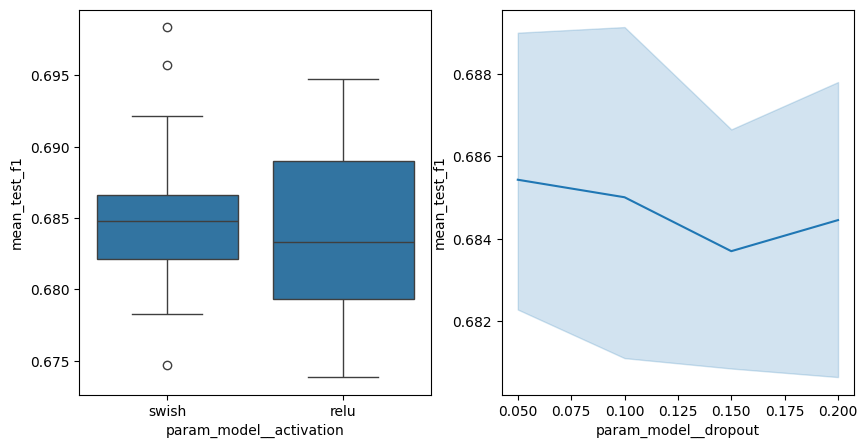

In [95]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_6, x='param_model__activation', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_6, x='param_model__dropout', y='mean_test_f1', ax=ax[1])

In [96]:
keras_scores_test_6.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.766953,0.712366,0.683910,0.692915
std,0.009830,0.015269,0.014414,0.014500
min,0.751412,0.693773,0.666210,0.675300
25%,0.766102,0.703495,0.678688,0.686967
50%,0.766968,0.708591,0.683476,0.691515
75%,0.772881,0.726256,0.685159,0.695859
max,0.777401,0.729715,0.706018,0.714931


In [97]:
keras_scores_train_6.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.820354,0.789276,0.747495,0.761628
std,0.014908,0.020260,0.023354,0.023627
min,0.801356,0.764075,0.713939,0.727997
25%,0.812942,0.777963,0.740722,0.755433
50%,0.816615,0.784595,0.743941,0.756613
75%,0.833898,0.807817,0.765306,0.779980
max,0.836960,0.811929,0.773568,0.788115


In [119]:
keras_estimators_6

[KerasClassifier(
 	model=<function create_model_3 at 0x00000238BC1B4860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons2=36
 ),
 KerasClassifier(
 	model=<function create_model_3 at 0x00000238BC1B4860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.05
 	model__hidden_neurons2=36
 ),
 KerasClassifier(
 	model=<function create_model_3 at 0x00000238BC1B4860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None


In [120]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__dropout': [0.2]
}
keras_sequential_dropout_estimators_final, keras_sequential_dropout_scores_train_final, keras_sequential_dropout_scores_test_final, keras_sequential_dropout_cv_results_final = train(features, targets, keras_sequential_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [121]:
keras_sequential_dropout_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.765595,0.709271,0.678387,0.686363
std,0.014292,0.017594,0.009002,0.010645
min,0.745763,0.687755,0.667892,0.675116
25%,0.759050,0.700440,0.676088,0.682693
50%,0.764972,0.706553,0.677267,0.684495
75%,0.776271,0.717340,0.677909,0.685562
max,0.781921,0.734266,0.692782,0.703947


In [122]:
keras_sequential_dropout_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.802272,0.761076,0.722418,0.734372
std,0.003259,0.001783,0.009752,0.008982
min,0.797966,0.758450,0.707653,0.720369
25%,0.800282,0.760368,0.717361,0.730596
50%,0.802487,0.761167,0.727416,0.738443
75%,0.804465,0.762535,0.728839,0.740266
max,0.806160,0.762859,0.730822,0.742187


In [123]:
def create_model_4(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=36):
    input = Input(shape=(36,))
    x = (Dense(hidden_neurons1, activation=activation))(input)
    x = (Dense(hidden_neurons2, activation=activation))(x) + (Dense(hidden_neurons2, activation=activation))(input)
    x = (Dense(12, activation=activation))(x)
    x = (Dense(3, activation='softmax'))(x)
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model

In [124]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [24, 36, 48],
    'model__activation': ['swish', 'relu'],
}
keras_model = KerasClassifier(model=create_model_4, verbose=0)
keras_estimators_7, keras_scores_train_7, keras_scores_test_7, keras_cv_results_7 = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__hidden_neurons2', ylabel='mean_test_f1'>

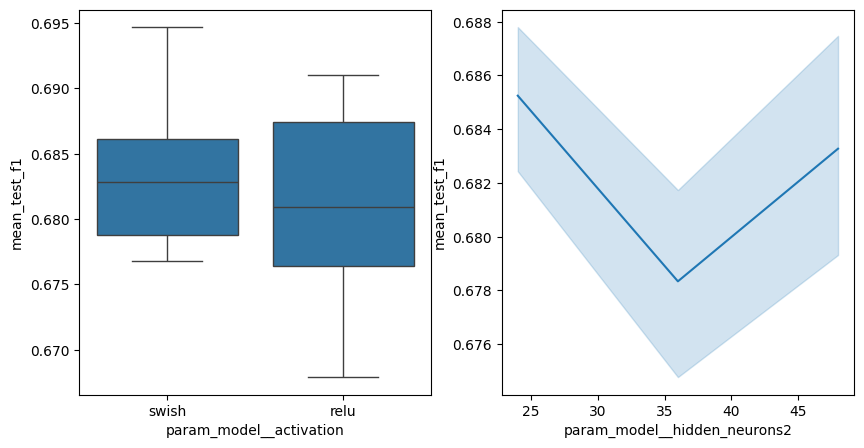

In [125]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_7, x='param_model__activation', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_7, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[1])

In [126]:
keras_scores_test_7.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.764243,0.708088,0.675561,0.684273
std,0.012129,0.011029,0.008177,0.007847
min,0.748023,0.696041,0.665541,0.676160
25%,0.754802,0.698300,0.668723,0.676861
50%,0.769492,0.709247,0.677512,0.684374
75%,0.774011,0.714517,0.681378,0.690176
max,0.774887,0.722335,0.684654,0.693796


In [127]:
keras_scores_train_7.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.827476,0.801695,0.754457,0.770375
std,0.008907,0.012862,0.011126,0.012038
min,0.816102,0.782026,0.739441,0.752988
25%,0.823114,0.799497,0.753382,0.769746
50%,0.826787,0.801811,0.753753,0.770030
75%,0.831591,0.808478,0.754888,0.772197
max,0.839785,0.816661,0.770822,0.786915


In [141]:
keras_estimators_7

[KerasClassifier(
 	model=<function create_model_4 at 0x0000023A77AA2DE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=relu
 	model__hidden_neurons2=36
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x0000023A77AA2DE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons2=48
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x0000023A77AA2DE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_

In [139]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [24],
    'model__activation': ['swish'],
}
keras_model_estimators_final, keras_model_scores_train_final, keras_model_scores_test_final, keras_model_cv_results_final = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [144]:
keras_model_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.767632,0.708935,0.681500,0.689667
std,0.009909,0.013730,0.011118,0.011841
min,0.753672,0.691568,0.669733,0.676814
25%,0.761582,0.701467,0.672646,0.680431
50%,0.771493,0.710756,0.681898,0.691158
75%,0.772881,0.712426,0.685574,0.693041
max,0.778531,0.728459,0.697651,0.706892


In [145]:
keras_model_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.812557,0.776920,0.737386,0.750556
std,0.001089,0.004546,0.002309,0.002456
min,0.811246,0.769184,0.735416,0.747554
25%,0.811811,0.777187,0.736100,0.749685
50%,0.812712,0.778325,0.736825,0.750449
75%,0.812942,0.778864,0.737275,0.750755
max,0.814072,0.781041,0.741318,0.754339


In [142]:
def create_model_5(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=36, dropout=0.1):
    input = Input(shape=(36,))
    x = (Dense(hidden_neurons1, activation=activation))(input)
    x = (Dense(hidden_neurons2, activation=activation))(x) + (Dense(hidden_neurons2, activation=activation))(input)
    x = (Dropout(dropout))(x)
    x = (Dense(12, activation=activation))(x)
    x = (Dense(3, activation='softmax'))(x)
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model

In [143]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [24],
    'model__activation': ['swish'],
    'model__dropout': [0.05, 0.1, 0.15, 0.2]
}
keras_model_dropout = KerasClassifier(model=create_model_5, verbose=0)
keras_estimators_8, keras_scores_train_8, keras_scores_test_8, keras_cv_results_8 = train(features, targets, keras_model_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

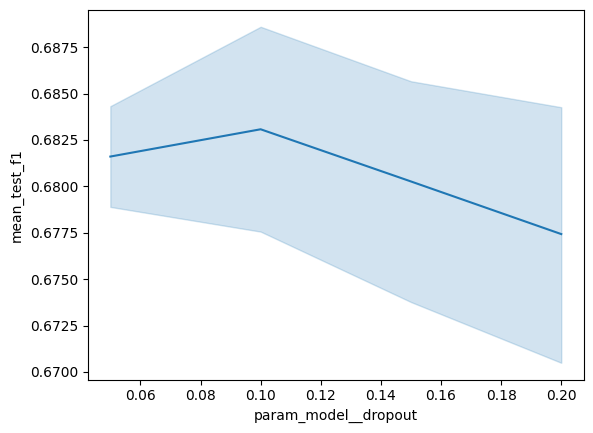

In [150]:
sb.lineplot(data=keras_cv_results_8, x='param_model__dropout', y='mean_test_f1')

In [151]:
keras_scores_test_8.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.760624,0.696865,0.670156,0.676760
std,0.008770,0.013618,0.011364,0.013054
min,0.746893,0.685906,0.653926,0.659078
25%,0.760181,0.686819,0.665291,0.672305
50%,0.760452,0.688750,0.670819,0.673820
75%,0.764972,0.707487,0.677181,0.685696
max,0.770621,0.715362,0.683562,0.692902


In [152]:
keras_scores_train_8.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.808262,0.770546,0.729592,0.742533
std,0.005002,0.008744,0.009224,0.009788
min,0.803052,0.761268,0.720788,0.733605
25%,0.805595,0.763709,0.721435,0.734308
50%,0.805650,0.768390,0.727071,0.738680
75%,0.812094,0.778842,0.739063,0.752562
max,0.814919,0.780521,0.739603,0.753508


In [168]:
keras_estimators_8

[KerasClassifier(
 	model=<function create_model_5 at 0x000002397D93EB60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.05
 	model__hidden_neurons2=24
 ),
 KerasClassifier(
 	model=<function create_model_5 at 0x000002397D93EB60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons2=24
 ),
 KerasClassifier(
 	model=<function create_model_5 at 0x000002397D93EB60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None


In [153]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [24],
    'model__activation': ['swish'],
    'model__dropout': [0.1]
}
keras_model_dropout_estimators_final, keras_model_dropout_scores_train_final, keras_model_dropout_scores_test_final, keras_model_dropout_cv_results_final = train(features, targets, keras_model_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [156]:
keras_model_dropout_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.771247,0.713590,0.683468,0.691770
std,0.012017,0.020923,0.014194,0.016456
min,0.758192,0.697422,0.671922,0.679216
25%,0.763842,0.698826,0.672582,0.680191
50%,0.768100,0.702837,0.678365,0.684476
75%,0.777401,0.722451,0.688606,0.696430
max,0.788701,0.746417,0.705864,0.718539


In [157]:
keras_model_dropout_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.805153,0.766074,0.727937,0.740041
std,0.003426,0.007020,0.006622,0.007007
min,0.802487,0.757599,0.720831,0.733332
25%,0.802769,0.764002,0.723560,0.734521
50%,0.803052,0.764917,0.725383,0.737380
75%,0.807290,0.766871,0.734379,0.746272
max,0.810169,0.776983,0.735534,0.748701


In [167]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Accuracy:','Precision:','Recall:', 'F1:'],
    'Keras Sequential Train': [keras_sequential_scores_train_final['accuracy'].mean(),keras_sequential_scores_train_final['precision'].mean(), keras_sequential_scores_train_final['recall'].mean(), keras_sequential_scores_train_final['f1'].mean()],
    'Keras Sequential Test': [keras_sequential_scores_test_final['accuracy'].mean(),keras_sequential_scores_test_final['precision'].mean(), keras_sequential_scores_test_final['recall'].mean(), keras_sequential_scores_test_final['f1'].mean()],
    'Keras Sequential Dropout Train': [keras_sequential_dropout_scores_train_final['accuracy'].mean(),keras_sequential_dropout_scores_train_final['precision'].mean(), keras_sequential_dropout_scores_train_final['recall'].mean(), keras_sequential_dropout_scores_train_final['f1'].mean()],
    'Keras Sequential Dropout Test': [keras_sequential_dropout_scores_test_final['accuracy'].mean(),keras_sequential_dropout_scores_test_final['precision'].mean(), keras_sequential_dropout_scores_test_final['recall'].mean(), keras_sequential_dropout_scores_test_final['f1'].mean()],
    'Keras Model Train': [keras_model_scores_train_final['accuracy'].mean(),keras_model_scores_train_final['precision'].mean(), keras_model_scores_train_final['recall'].mean(), keras_model_scores_train_final['f1'].mean()],
    'Keras Model Test': [keras_model_scores_test_final['accuracy'].mean(),keras_model_scores_test_final['precision'].mean(), keras_model_scores_test_final['recall'].mean(), keras_model_scores_test_final['f1'].mean()],
    'Keras Model Dropout Train': [keras_model_dropout_scores_train_final['accuracy'].mean(),keras_model_dropout_scores_train_final['precision'].mean(), keras_model_dropout_scores_train_final['recall'].mean(), keras_model_dropout_scores_train_final['f1'].mean()],
    'Keras Model Dropout Test': [keras_model_dropout_scores_test_final['accuracy'].mean(),keras_model_dropout_scores_test_final['precision'].mean(), keras_model_dropout_scores_test_final['recall'].mean(), keras_model_dropout_scores_test_final['f1'].mean()],
    })
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,Keras Sequential Train,Keras Sequential Test,Keras Sequential Dropout Train,Keras Sequential Dropout Test,Keras Model Train,Keras Model Test,Keras Model Dropout Train,Keras Model Dropout Test
Metric,,,,,,,,
Accuracy:,0.815721,0.766275,0.802272,0.765595,0.812557,0.767632,0.805153,0.771247
Precision:,0.782119,0.709325,0.761076,0.709271,0.776920,0.708935,0.766074,0.713590
Recall:,0.745201,0.683974,0.722418,0.678387,0.737386,0.681500,0.727937,0.683468
F1:,0.758015,0.692135,0.734372,0.686363,0.750556,0.689667,0.740041,0.691770
